In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

california_dataset = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(california_dataset.data, california_dataset.target, test_size=0.2, random_state=42)

In [2]:
import numpy as np
from tqdm import tqdm

class LinearRegressionGradientDescent:
    def __init__(self, x, y, learning_rate):
        self.x = x
        self.y = y
        self.learning_rate = learning_rate

        assert x.shape[0] == y.shape[0], "The number of samples in x_train and y_train must be equal"

        self.num_samples = y.shape[0]
        self.num_features = x.shape[1]

        self.bias = np.zeros((1, 1))
        self.weights = np.zeros((self.num_features, 1))

    def predict(self, bias, weights, x):
        return np.dot(x, weights) + bias

    def loss(self, target, predicted):
        # MSE loss
        return np.mean(np.square(target - predicted))
    
    def step(self):
        # Make predictions using the current weights and bias
        predicted = self.predict(self.bias, self.weights, self.x)
        # Get the loss 
        loss = self.loss(self.y, predicted)
        # Calculate the gradients
        delta_weights = 1 / self.num_samples * np.dot(self.x.T, (predicted - self.y.reshape(-1, 1)))
        delta_bias = 1 / self.num_samples * np.sum(predicted - self.y.reshape(-1, 1))
        # Update the weights and bias
        self.weights = self.weights - self.learning_rate * delta_weights
        self.bias = self.bias - self.learning_rate * delta_bias
        return loss

In [3]:
import matplotlib.pyplot as plt
import numpy as np

iterations = 100
learning_rate = 10e-9
model = LinearRegressionGradientDescent(x_train, y_train, learning_rate)
losses = []
for iteration in tqdm(range(iterations), desc="Training"):
    loss = model.step()
    losses.append(loss)
weights = model.weights
bias = model.bias
iterations = np.arange(iterations)
plt.xlabel("Iteration")
plt.title("Iteration vs Loss")
plt.ylabel("Loss")
plt.plot(iterations, losses)

Training:  48%|████▊     | 48/100 [00:42<00:46,  1.13it/s]


KeyboardInterrupt: 

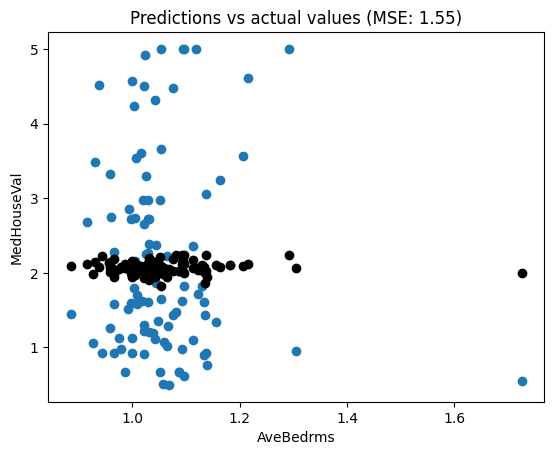

In [ ]:
def plot_predictions(num_samples: int, var_index: int, X_test, y_test, weights, bias) -> None:
    random_indices = np.random.choice(X_test.shape[0], num_samples)
    X_test = X_test[random_indices]
    y_test = y_test[random_indices]
    y_predicted = (np.dot(X_test, weights) + bias).flatten()

    # Calculate the MSE
    mse = np.mean(np.square(y_test - y_predicted))

    plt.xlabel(california_dataset.feature_names[var_index])
    plt.ylabel(california_dataset.target_names[0])
    plt.scatter(X_test[:,var_index], y_test) # Plot test data
    plt.scatter(X_test[:,var_index], y_predicted, color="k") # Plot predictions
    plt.title(f"Predictions vs actual values (MSE: {mse:.2f})")
    plt.show()

plot_predictions(100, 3, x_test, y_test, weights, bias)